<a href="https://colab.research.google.com/github/mark-ford123/applied_ml_cw_2025_mf/blob/main/coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

!kaggle datasets download -d nolasthitnotomorrow/radioml2016-deepsigcom --unzip

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/nolasthitnotomorrow/radioml2016-deepsigcom
License(s): CC-BY-NC-SA-4.0


In [2]:
import pickle
with open("RML2016.10a_dict.pkl", "rb") as f:
  Xd = pickle._Unpickler(f)
  Xd.encoding = "latin1"
  Xd = Xd.load()

In [4]:
import numpy as np

# Load dataset (modify path as needed)
data = Xd

# Extract modulations and SNR levels
modulations = list(set([key[0] for key in data.keys()]))
snrs = sorted(set([key[1] for key in data.keys()]))

# Convert dataset into structured format
X, y, snr_labels = [], [], []
for (mod, snr), signals in data.items():
    for sig in signals:
        X.append(sig)
        y.append(mod)
        snr_labels.append(snr)

X = np.array(X)
y = np.array(y)
snr_labels = np.array(snr_labels)

# Print dataset summary
print(f"Total samples: {len(X)}")
print(f"Unique modulations: {modulations}")
print(f"Unique SNR levels: {snrs}")

Total samples: 220000
Unique modulations: ['WBFM', 'PAM4', 'CPFSK', 'QPSK', 'QAM16', 'BPSK', 'QAM64', 'AM-DSB', 'GFSK', '8PSK', 'AM-SSB']
Unique SNR levels: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


Pre-processes the data to display the modulation types and SNR levels present within the 220,000 samples. This is a Quality-of-Life inclusion to ensure the dataset is easily understandable and interpretable.

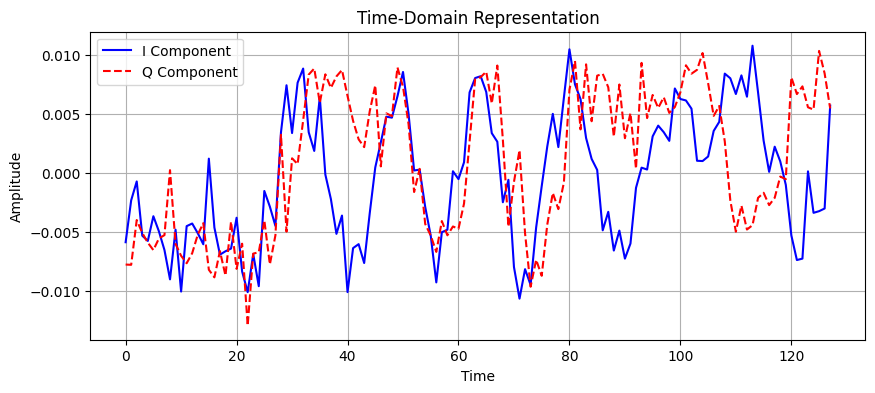

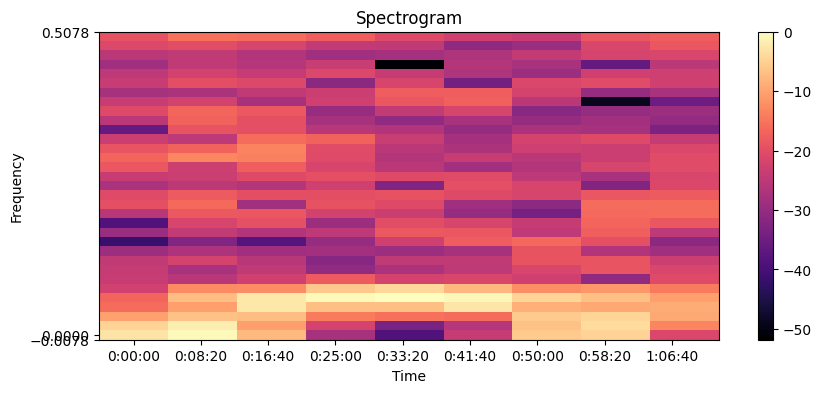

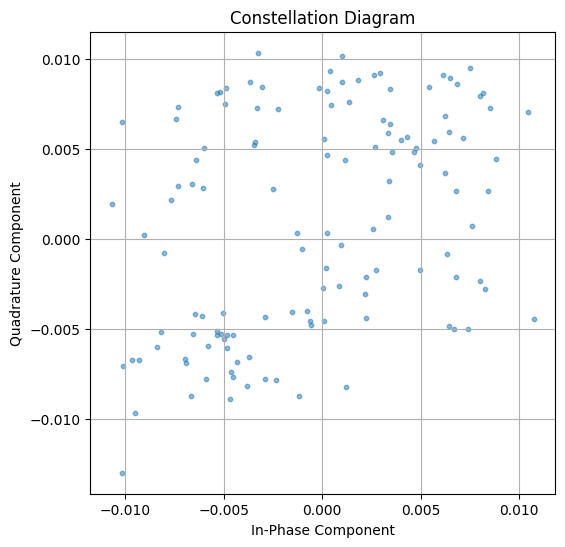

In [ ]:
import matplotlib.pyplot as plt
import librosa

# Extract one signal (first sample)
signal_i = X[0, 0, :]
signal_q = X[0, 1, :]

# Time-Domain Representation
plt.figure(figsize=(10, 4))
plt.plot(signal_i, label="I Component", color="b")
plt.plot(signal_q, label="Q Component", linestyle='dashed', color="r")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Time-Domain Representation")
plt.legend()
plt.grid()
plt.show()

# Spectrogram (STFT)
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(signal_i, n_fft=64)), ref=np.max)
librosa.display.specshow(D, sr=1, x_axis="time", y_axis="log")
plt.colorbar()
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

# Constellation Diagram
plt.figure(figsize=(6, 6))
plt.scatter(signal_i, signal_q, alpha=0.5, s=10)
plt.xlabel("In-Phase Component")
plt.ylabel("Quadrature Component")
plt.title("Constellation Diagram")
plt.grid()
plt.show()


In [5]:
# Compute signal energy
energy = np.linalg.norm(X, axis=(1, 2))

# Identify & remove outliers
mean_energy = np.mean(energy)
std_energy = np.std(energy)
threshold = mean_energy + 2 * std_energy
filtered_idx = np.where(energy < threshold)

X_clean = X[filtered_idx]
y_clean = y[filtered_idx]
snr_clean = snr_labels[filtered_idx]

print(f"Original dataset size: {X.shape[0]}")
print(f"Cleaned dataset size: {X_clean.shape[0]}")


Original dataset size: 220000
Cleaned dataset size: 219450


In larger datasets, cleaning the data (in this case by excluding data outside of two standard deviations from the mean), is a critically important part of data pre-processing to remove outliers that will be detrimental to the accuracy of the model, while being near-undetectable without significantly more advanced / computationally complex model implementations.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Min-Max scaling (range [-1, 1])
scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = np.array([scaler.fit_transform(sig.T).T for sig in X_clean])

# Standardization (zero mean, unit variance)
standardizer = StandardScaler()
X_standardized = np.array([standardizer.fit_transform(sig.T).T for sig in X_clean])


KeyboardInterrupt: 

Code doesn't work rn

In [6]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load the dataset (already unpickled)
Xd_dict = Xd  # Assuming Xd is your unpickled dataset

# Extract Modulations and SNRs
modulations = sorted(set([key[0] for key in Xd_dict.keys()]))  # Unique modulation types
snrs = sorted(set([key[1] for key in Xd_dict.keys()]))  # Unique SNR values

X = []  # Features (IQ samples)
y = []  # Labels (Modulation type)

# Iterate through the dictionary and extract data
for (mod_type, snr), samples in Xd_dict.items():
    for sample in samples:
        X.append(sample)  # Each sample is (2, 128)
        y.append(mod_type)  # The label is the modulation type

# Convert lists to NumPy arrays
X = np.array(X)  # Shape: (num_samples, 2, 128)
y = np.array(y)  # Shape: (num_samples,)

# Convert modulation labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert to integers

# One-hot encode the labels for TensorFlow
y_onehot = tf.keras.utils.to_categorical(y_encoded, num_classes=len(modulations))

# Split the dataset into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot)

# Reshape for CNN (channels last format)
X_train = X_train.reshape(-1, 128, 2, 1)  # Add a channel dimension
X_test = X_test.reshape(-1, 128, 2, 1)

print(f"Reshaped X_train: {X_train.shape}")  # (num_samples, 128, 2, 1)
print(f"Reshaped X_test: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")  # (num_samples, num_classes)
print(f"y_test shape: {y_test.shape}")


Reshaped X_train: (176000, 128, 2, 1)
Reshaped X_test: (44000, 128, 2, 1)
y_train shape: (176000, 11)
y_test shape: (44000, 11)


The data is split into two sections; data used to train the model, and data used to evaluate its prediction accuracy. The 80/20 split for training/testing is fairly standard within the industry. Increasing the amount of training data gives the model more data to learn from, but a generally less reliable evaluation. Whereas decreasing the amount of training data allows for better evaluations, but possibly poor generalizations, as it has not learnt as well. 80/20 strikes a good middle-ground.

Epoch 1/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.4042 - loss: 1.6163 - val_accuracy: 0.5188 - val_loss: 1.2603 - learning_rate: 3.0000e-04
Epoch 2/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.5184 - loss: 1.2788 - val_accuracy: 0.4923 - val_loss: 1.3879 - learning_rate: 3.0000e-04
Epoch 3/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.5396 - loss: 1.2263 - val_accuracy: 0.4417 - val_loss: 1.6890 - learning_rate: 3.0000e-04
Epoch 4/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.5570 - loss: 1.1838 - val_accuracy: 0.5515 - val_loss: 1.1956 - learning_rate: 1.5000e-04
Epoch 5/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.5647 - loss: 1.1610 - val_accuracy: 0.5616 - val_loss: 1.1661 - learning_rate: 1.5000e-04
Epoch 6/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.5715 - loss: 1.1441 - val_accuracy: 0.5591 - val_loss: 1.1812 - learning_rate: 1.5000e-04
Epoch 7/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 41s 

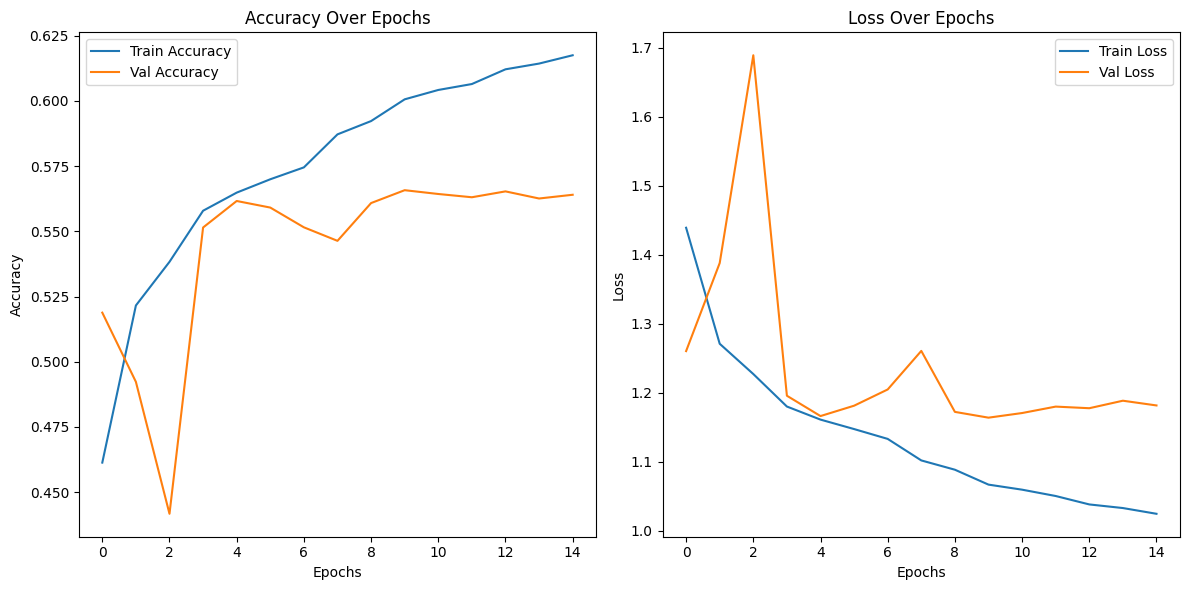

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


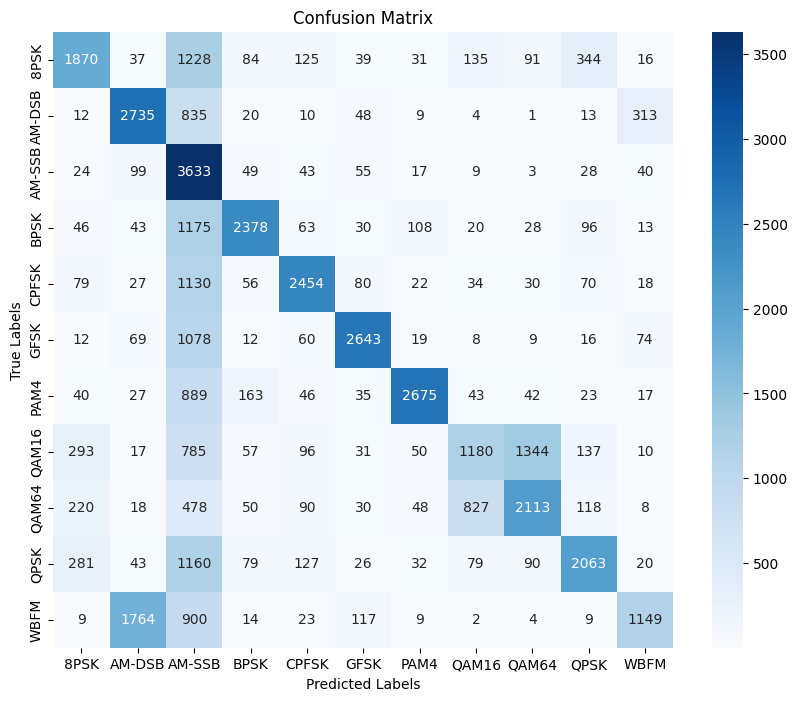

In [ ]:
from tf.keras import layers, models
from tf.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Data Preprocessing (same as before)

# Step 2: Build CNN-Transformer Hybrid Model with Adjustments

def build_cnn_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # CNN layers with BatchNormalization and dropout
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # Use 'same' padding to preserve dimensions

    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # Use 'same' padding to preserve dimensions

    x = layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # Use 'same' padding to preserve dimensions

    # Residual block to help model with deeper layers
    residual = x
    x = layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])  # Add residual connection

    # Flatten the output for the Transformer
    x = layers.Flatten()(x)

    # Transformer Layer
    transformer_input = layers.Reshape((-1, 128))(x)  # Reshape for transformer
    transformer = layers.MultiHeadAttention(num_heads=4, key_dim=128)(transformer_input, transformer_input)
    transformer = layers.Add()([transformer_input, transformer])  # Residual connection
    transformer = layers.LayerNormalization()(transformer)

    # Feed-forward network after Transformer
    transformer = layers.Dense(128, activation="relu")(transformer)

    # Flatten the transformer output
    transformer = layers.Flatten()(transformer)

    # Fully connected layer
    x = layers.Dense(512, activation="relu", kernel_initializer="he_normal")(transformer)
    x = layers.Dropout(0.6)(x)  # Increased dropout for regularization

    # Output layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="cnn_transformer_model")
    return model

# Step 3: Compile the model with Nadam optimizer for potential improvement
model = build_cnn_transformer_model((128, 2, 1), num_classes=len(modulations))

# Compile the model with a smaller learning rate and Nadam optimizer
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0003), loss="categorical_crossentropy", metrics=["accuracy"])

# Step 4: Set up callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

# Step 5: Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stop, lr_scheduler])

# Step 6: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Step 7: Plot Training History
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Step 8: Confusion Matrix

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=modulations, yticklabels=modulations)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


CNN-Transformer Model Without Autoencoder

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("--- Scenario 2: Training Baseline Model with Autoencoder ---")

# Step 1: Define and Train Autoencoder
def build_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)
    # Encoder
    x = layers.Conv2D(32, (3, 1), activation='relu', padding='same')(input_img)
    x = layers.Conv2D(32, (1, 2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 1), padding='same')(x) # (64, 2, 32)
    x = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (1, 2), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 1), padding='same')(x) # (32, 2, 64)
    # Decoder
    x = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(encoded)
    x = layers.Conv2D(64, (1, 2), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 1))(x) # (64, 2, 64)
    x = layers.Conv2D(32, (3, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(32, (1, 2), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 1))(x) # (128, 2, 32)
    decoded = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(x) # Linear activation
    autoencoder = models.Model(input_img, decoded, name="autoencoder")
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

print("\nBuilding Autoencoder...")
autoencoder = build_autoencoder(input_shape)
autoencoder.summary()

print("\nTraining Autoencoder...")
# Use reasonable AE training parameters
ae_epochs = 20 # Might need more/less depending on convergence
ae_batch_size = 128
ae_start_time = time.time()
autoencoder.fit(X_train, X_train,
                epochs=ae_epochs,
                batch_size=ae_batch_size,
                shuffle=True,
                validation_split=0.1,
                callbacks=[
                    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
                ],
                verbose=2)
ae_end_time = time.time()
print(f"\nAE Training took {ae_end_time - ae_start_time:.2f} seconds.")

# Step 2: Denoise Data using Trained Autoencoder
print("\nDenoising data using trained autoencoder...")
denoise_start_time = time.time()
X_train_cleaned = autoencoder.predict(X_train, batch_size=ae_batch_size * 2) # Use larger batch for prediction
X_test_cleaned = autoencoder.predict(X_test, batch_size=ae_batch_size * 2)
denoise_end_time = time.time()
print(f"Denoising took {denoise_end_time - denoise_start_time:.2f} seconds.")
print("X_train_cleaned shape:", X_train_cleaned.shape)
print("X_test_cleaned shape:", X_test_cleaned.shape)

# Step 3: Build the exact CNN-Transformer Model (using the same function as Scenario 1)
def build_baseline_cnn_transformer_model(input_shape, num_classes):
    # PASTE THE EXACT SAME FUNCTION DEFINITION FROM SCENARIO 1 HERE
    inputs = layers.Input(shape=input_shape)
    # CNN layers with (2, 2) pooling
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    # Questionable residual block
    residual = x
    x = layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual]) # Original Add layer
    # Flatten and Reshape
    x = layers.Flatten()(x) # Shape becomes (batch, 2048)
    transformer_input = layers.Reshape((16, 128))(x) # Sequence length 16
    # Transformer Layer (original structure)
    transformer = layers.MultiHeadAttention(num_heads=4, key_dim=128)(transformer_input, transformer_input)
    transformer = layers.Add()([transformer_input, transformer])
    transformer = layers.LayerNormalization()(transformer)
    transformer = layers.Dense(128, activation="relu")(transformer) # FFN part
    transformer = layers.Flatten()(transformer) # Flatten sequence
    # Fully connected layer
    x = layers.Dense(512, activation="relu", kernel_initializer="he_normal")(transformer)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs=inputs, outputs=outputs, name="baseline_cnn_transformer")
    return model


# Step 4: Compile the model
model_with_ae = build_baseline_cnn_transformer_model(input_shape, num_classes) # Build the same model
model_with_ae.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0003),
                      loss="categorical_crossentropy",
                      metrics=["accuracy"])
print("\nModel with AE Summary:")
# model_with_ae.summary() # Optional: summary is same as baseline

# Step 5: Callbacks (use same callbacks)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# Step 6: Train the model using CLEANED data
print("\nTraining Model with AE Preprocessing...")
epochs = 30
batch_size = 64
start_time = time.time()
# *** Feed the CLEANED data ***
history_with_ae = model_with_ae.fit(X_train_cleaned, y_train,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_data=(X_test_cleaned, y_test), # Use cleaned test data
                                    callbacks=[lr_scheduler],
                                    verbose=2) # Use verbose=2 for epoch logs
end_time = time.time()
print(f"\nTraining with AE took {end_time - start_time:.2f} seconds.")

# Step 7: Evaluate the model
print("\nEvaluating Model with AE...")
test_loss_with_ae, test_accuracy_with_ae = model_with_ae.evaluate(X_test_cleaned, y_test, verbose=0)
print(f"With AE Test Loss: {test_loss_with_ae:.4f}")
print(f"With AE Test Accuracy: {test_accuracy_with_ae * 100:.2f}%")

--- Scenario 2: Training Baseline Model with Autoencoder ---

Building Autoencoder...


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 2, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 2, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 128, 2, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 64, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 64, 2, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 2, 64)      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 2, 64)      │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 2, 64)      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 64, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 64, 2, 32)      │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 64, 2, 32)      │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 128, 2, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 128, 2, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,825 (179.00 KB)

 Trainable params: 45,825 (179.00 KB)

 Non-trainable params: 0 (0.00 B)


Training Autoencoder...
Epoch 1/20
1238/1238 - 26s - 21ms/step - loss: 1.6131e-05 - val_loss: 1.1466e-05 - learning_rate: 1.0000e-03
Epoch 2/20
1238/1238 - 15s - 12ms/step - loss: 1.0313e-05 - val_loss: 7.3800e-06 - learning_rate: 1.0000e-03
Epoch 3/20

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1238/1238 - 14s - 11ms/step - loss: 4.2562e-06 - val_loss: 2.9107e-06 - learning_rate: 1.0000e-03
Epoch 4/20
1238/1238 - 14s - 11ms/step - loss: 2.5504e-06 - val_loss: 2.3631e-06 - learning_rate: 5.0000e-04
Epoch 5/20

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1238/1238 - 14s - 11ms/step - loss: 2.1351e-06 - val_loss: 1.9653e-06 - learning_rate: 5.0000e-04
Epoch 6/20
1238/1238 - 14s - 11ms/step - loss: 1.8686e-06 - val_loss: 1.8101e-06 - learning_rate: 2.5000e-04
Epoch 7/20

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1238/1238 - 21s - 17ms/step - loss: 1.7860e-06 - val_loss: 1.7485e-06 - learnin

Calculating and visualizing confusion matrix heatmap...
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


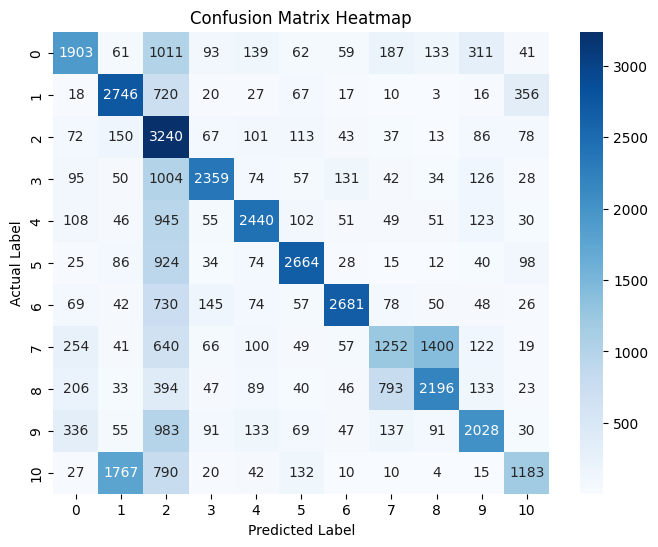

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Ensure these variables exist from your Scenario 2 run ---
# model_with_ae: Your trained tf.keras.Model
# X_test_cleaned: The AE-processed test data
# y_test: The one-hot encoded true labels for the test set
# modulations: Optional list of class names for labels
# -------------------------------------------------------------

print("Calculating and visualizing confusion matrix heatmap...")

# 1. Get predicted labels
y_pred_probs = model_with_ae.predict(X_test_cleaned)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 2. Get true labels
y_true_labels = np.argmax(y_test, axis=1)

# 3. Calculate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# 4. Plot heatmap
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues") # annot=True shows numbers, fmt="d" formats as integer
plt.title('Confusion Matrix Heatmap')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

CNN-Transformer Model With Autoencoder

In [ ]:
# Define CNN Model
model = Sequential([
    Input(shape=(128,2,1)),

    Conv2D(64, kernel_size=(3,3), activation='relu', padding="same", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,1)),

    Conv2D(128, kernel_size=(3,3), activation='relu', padding="same", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,1)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),  # Reduce dropout slightly
    Dense(11, activation='softmax')
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train Model with Early Stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,  # Allow more training time
    batch_size=128,  # ✅ Reduced batch size (was 256)
    callbacks=[early_stop, lr_scheduler]
)

# ✅ Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2%}")


Epoch 1/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.3172 - loss: 2.4305 - val_accuracy: 0.4606 - val_loss: 1.9473 - learning_rate: 5.0000e-05
Epoch 2/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.4508 - loss: 1.9289 - val_accuracy: 0.4949 - val_loss: 1.7628 - learning_rate: 5.0000e-05
Epoch 3/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.4891 - loss: 1.7504 - val_accuracy: 0.4868 - val_loss: 1.6811 - learning_rate: 5.0000e-05
Epoch 4/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5081 - loss: 1.6347 - val_accuracy: 0.5223 - val_loss: 1.5709 - learning_rate: 5.0000e-05
Epoch 5/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.5249 - loss: 1.5481 - val_accuracy: 0.5269 - val_loss: 1.5144 - learning_rate: 5.0000e-05
Epoch 6/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5338 - loss: 1.4846 - val_accuracy: 0.5237 - val_loss: 1.4817 - learning_rate: 5.0000e-05
Epoch 7/30
1375/1375 ━━━━━━━━━━━━━━━━━━━

This has implemented a **Convolutional Neural Network**.

In [ ]:
# Define CNN-LSTM Model
model_cnn_lstm = Sequential([
    Input(shape=(128, 2, 1)),  # Input shape (128 time steps, 2 features, 1 channel)

    # CNN Layer 1
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),

    # CNN Layer 2
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),

    # Reshape to make it compatible with LSTM
    Reshape((64, 128)),  # Reshape the output to (batch_size, time_steps, features)

    # LSTM Layer
    LSTM(128, return_sequences=True),  # Set return_sequences=True for stacking with another LSTM if needed
    LSTM(64),  # Add another LSTM layer for more complex sequence modeling

    # Fully Connected Layers
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(11, activation='softmax')  # Assuming 11 classes for classification
])

# Compile Model
model_cnn_lstm.compile(optimizer=Adam(learning_rate=0.00005),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train Model with Early Stopping and Learning Rate Scheduler
history_cnn_lstm = model_cnn_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,  # Allow more training time
    batch_size=128,  # Batch size
    callbacks=[early_stop, lr_scheduler]
)

# Evaluate Model
test_loss_cnn_lstm, test_acc_cnn_lstm = model_cnn_lstm.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc_cnn_lstm:.2%}")


Epoch 1/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - accuracy: 0.2736 - loss: 2.1625 - val_accuracy: 0.4028 - val_loss: 1.7466 - learning_rate: 5.0000e-05
Epoch 2/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.4308 - loss: 1.6638 - val_accuracy: 0.4852 - val_loss: 1.5300 - learning_rate: 5.0000e-05
Epoch 3/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.4747 - loss: 1.5366 - val_accuracy: 0.4589 - val_loss: 1.5905 - learning_rate: 5.0000e-05
Epoch 4/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.4922 - loss: 1.4754 - val_accuracy: 0.4665 - val_loss: 1.5175 - learning_rate: 5.0000e-05
Epoch 5/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.5042 - loss: 1.4338 - val_accuracy: 0.3976 - val_loss: 1.8145 - learning_rate: 5.0000e-05
Epoch 6/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.5096 - loss: 1.4129 - val_accuracy: 0.5122 - val_loss: 1.4006 - learning_rate: 5.0000e-05
Epoch 7/30
1375/1375 ━━━━━━━━━━━━━━━━━━━

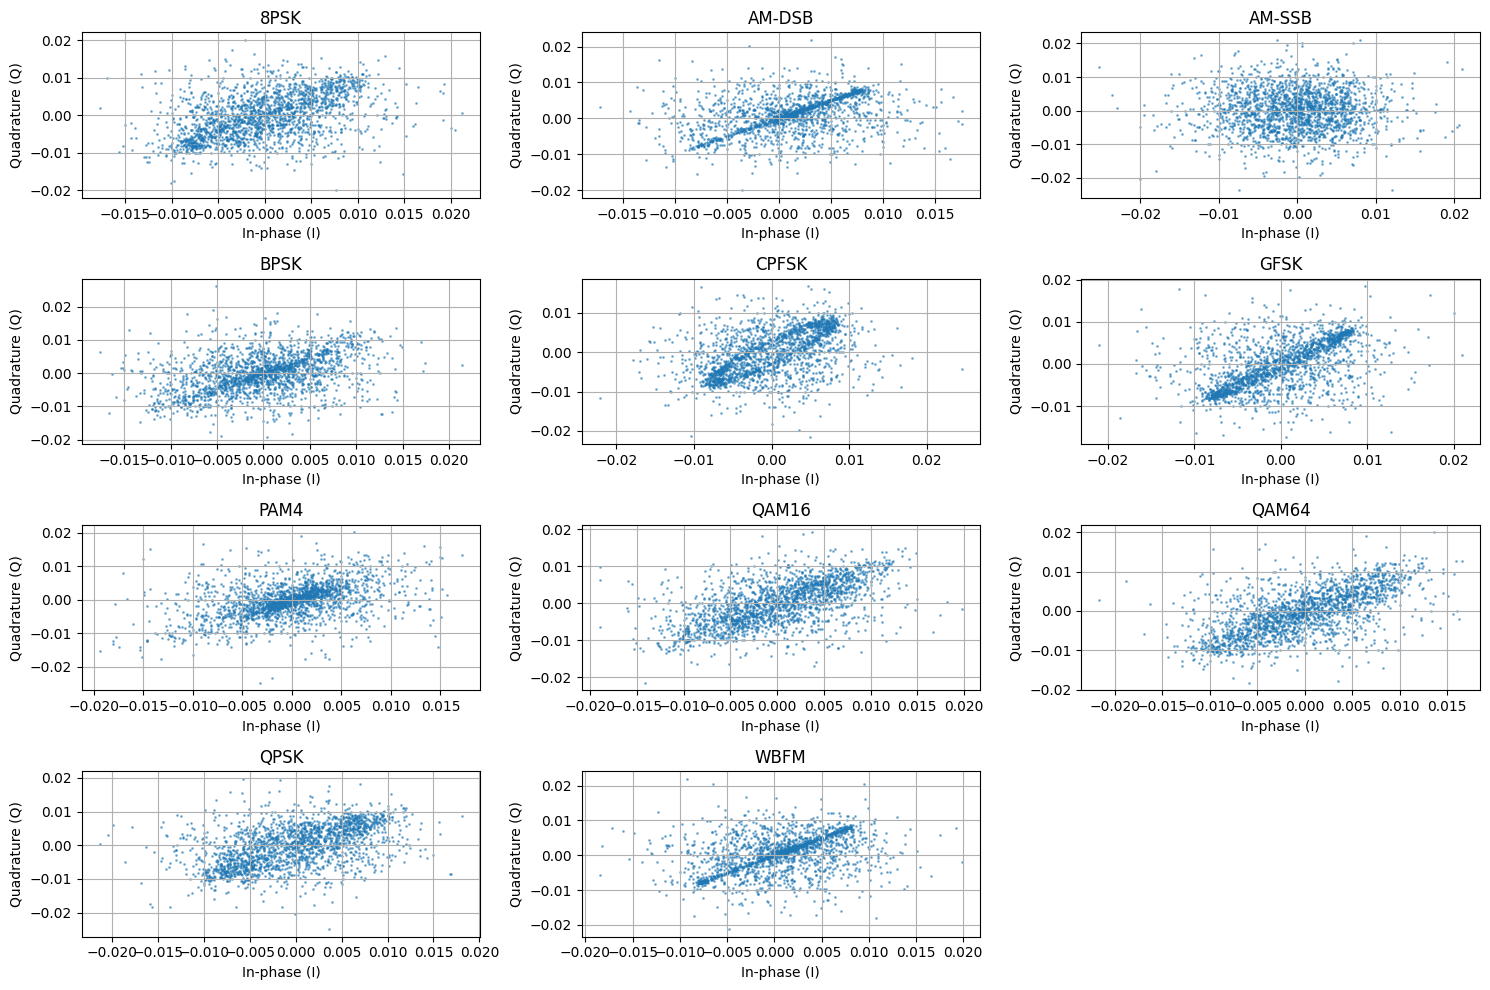

In [ ]:
# Select a subset of the dataset for visualization
def plot_constellation(X_data, y_data, modulations, num_samples=1000):
    """
    Plots constellation diagrams for different modulation types.

    X_data: IQ samples (shape: samples x 2 x 128)
    y_data: Labels (one-hot encoded)
    modulations: List of modulation names
    num_samples: Number of points to plot per modulation type
    """

    # Convert one-hot encoding to integer labels
    labels = np.argmax(y_data, axis=1)

    # Set up the plot
    plt.figure(figsize=(15, 10))

    for mod_idx, modulation in enumerate(modulations):
        plt.subplot(4, 3, mod_idx + 1)  # Adjust grid based on modulation count

        # Extract samples belonging to the current modulation type
        iq_samples = X_data[labels == mod_idx][:num_samples]  # Select samples

        # Reshape and take I/Q components
        I = iq_samples[:, 0, :].flatten()  # In-phase component
        Q = iq_samples[:, 1, :].flatten()  # Quadrature component

        # Scatter plot
        plt.scatter(I, Q, alpha=0.5, s=1)
        plt.title(modulation)
        plt.xlabel("In-phase (I)")
        plt.ylabel("Quadrature (Q)")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call function to visualize
plot_constellation(X_train, y_train, modulations)


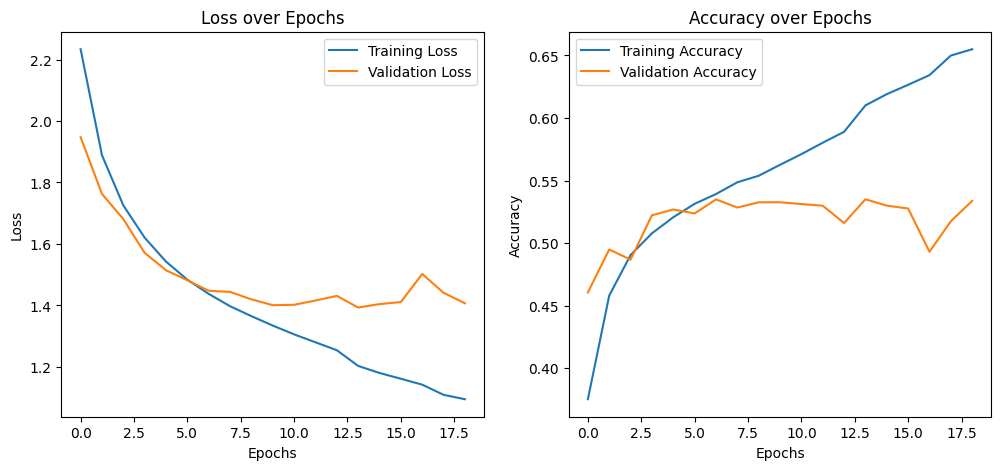

In [ ]:
# Extract values from history
epochs = range(len(history.history['loss']))
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.show()


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


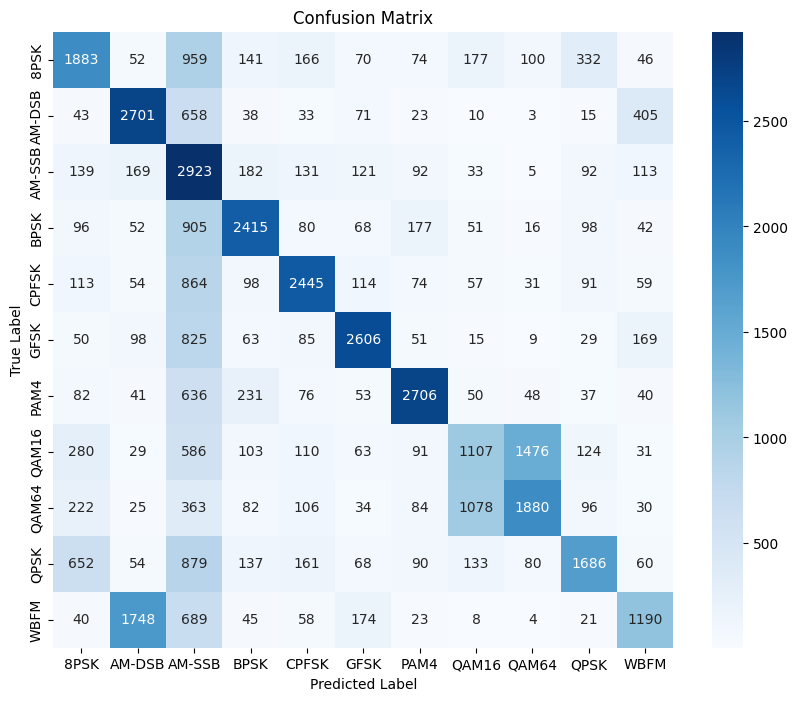

In [ ]:
from sklearn.metrics import confusion_matrix

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class index
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class index

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()